In [1]:


from commonfunctions import *
inpath = '../inputs/'
outpath = '../outputs/segmentation/'
import time
import joblib

# load model
filename = '../music_notes_NN.joblib.pkl'
nn = joblib.load(filename)
classes = nn.classes_

line_to_char = {}
line_to_char[13] = 'c1'
line_to_char[12] = 'd1'
line_to_char[11] = 'e1'
line_to_char[10] = 'f1'
line_to_char[9] = 'g1'
line_to_char[8] = 'a1'
line_to_char[7] = 'b1'
line_to_char[6] = 'c2'
line_to_char[5] = 'd2'
line_to_char[4] = 'e2'
line_to_char[3] = 'f2'
line_to_char[2] = 'g2'
line_to_char[1] = 'a2'
line_to_char[0] = 'b2'

In [2]:
target_img_size = (32, 32) 
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

def getContours(img):
    kernel = np.array([
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]
    ], np.uint8)
    img = cv2.dilate(img,kernel,iterations = 10) # to merge 2 number together
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if w > d // 2 and h > d:
            i = len(boxes) - 1
            if i == -1 or not (x + w <= boxes[i][0] + boxes[i][2] and x >= boxes[i][0]): # remove overlaped contours
                boxes.append((x, y, w, h))

    return np.array(boxes)

def xProjection(img, r):
    "Return a list containing the sum of the pixels in each column"
    (h, w) = img.shape[:2]
    sumCols = []
    for j in range(0, w, r):
        mx = 0
        tmp = 0
        for i in range(h):
            if np.all(img[i, j : j + r] == 255):
                tmp += 1
            else:
                mx = max(mx, tmp)
                tmp = 0
        mx = max(mx, tmp)    
        sumCols.append(mx)
    return np.array(sumCols)

def yProjection(img, r):
    "Return a list containing the sum of the pixels in each row"
    (h, w) = img.shape[:2]
    sumRows = []
    for i in range(0, h, r):
        tmp = 0
        for j in range(w):
            if img[i : i + r, j] == 255:
                tmp += 1
        sumRows.append(tmp)
    return np.array(sumRows)

def getBeamHeads(img, d):
    x = xProjection(img, 8)
    x[x < d // 2] = 0
    
    points = []
    tx1, tx2 = -1, -1
    for i in range(len(x)):
        if x[i]:
            if tx1 == -1:
                tx1 = i * 8

        elif tx1 != -1:
            tx2 = i * 8
            points.append((tx1, tx2))
            tx1, tx2 = -1, -1
            
    if tx1 != -1:
        tx2 = (len(x) - 1) * 8
        points.append((tx1, tx2))
        
    mask = img.copy()
    mask[:] = 0

    (h, w) = img.shape[:2]
    for px1, px2 in points:
        cv2.rectangle(mask,(px1,0),(px2,h),(255,255,255),-1)
    
    img[mask != 255] = 0
    kernel = np.ones((3,3), np.uint8)
    img = cv2.erode(img,kernel,iterations = 3)

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if h > d // 2:
            i = len(boxes) - 1
            if i == -1 or not (x + w <= boxes[i][0] + boxes[i][2] and x >= boxes[i][0]): # remove overlaped contours
                boxes.append((x, y, w, h))
                
                    
    return np.array(boxes)

def getNoteHeads(img, d):
    y = yProjection(img, 1)
    th = np.max(y) - 5
    y[y < th] = 0

    points = []
    ty1, ty2 = -1, -1
    for i in range(len(y)):
        if y[i]:
            if ty1 == -1:
                ty1 = i

        elif ty1 != -1:
            ty2 = i
            points.append((ty1, ty2))
            ty1, ty2 = -1, -1
            
    if ty1 != -1:
        ty2 = (len(y) - 1)
        points.append((ty1, ty2))

    boxes = []
    (h, w) = img.shape[:2]
    
    if len(points):
        points = sorted(points)
        y1, y2 = points[0]
        boxes.append((0,y1,w,y2-y1))
    
    return np.array(boxes)

def getLines(img):
    img *= 255
    img = 255 - img
    y =  yProjection(img, 1)
    y[y < 100] = 0
        
    points = []
    ty1, ty2 = -1, -1
    for i in range(len(y)):
        if y[i]:
            if ty1 == -1:
                ty1 = i

        elif ty1 != -1:
            ty2 = i
            points.append((ty1, ty2))
            ty1, ty2 = -1, -1

    if ty1 != -1:
        ty2 = (len(y) - 1)
        points.append((ty1, ty2))
    
    points = np.array(points)
    points = [(p[0] + p[1]) // 2 for p in points]
        
    d = 0
    for i in range(1, len(points)):
        d += abs(points[i - 1] - points[i])
    d //= len(points) - 1
    
    p1 = points[0]
    for i in range(1):
        tmp = p1 - (i + 1) * d
        points.insert(0, tmp)
    p1 = points[-1]
    for i in range(1):
        tmp = p1 + (i + 1) * d
        points.append(tmp)
        
    tmp_points = []
    
    for p in points:
        tmp_points.append(p)
        tmp_points.append(p + (d // 2))
    
    tmp_points.pop(len(tmp_points) - 1)
    p1 = tmp_points[0] - (d // 2)
    tmp_points.insert(0, p1)
    
    return tmp_points, d

In [3]:
 def get_candidates_lines(bimg, thickness):
    fimg = np.copy(bimg)
    candidates = [] # Contains list of candidate staffs lines (row, begin, height)
    cols = fimg.shape[1]
    rows = fimg.shape[0]
    delta = max(1 , thickness//3)
    t2 = thickness+ delta
    t1 = abs(thickness-delta)
    flag = False
    for i in range(cols):
        for j in range(rows):
            if fimg[j,i] == 0 and flag == False:
                beg = j
                flag = True
            elif fimg[j,i] == 1 and flag == True:
                flag = False
                if j-beg > t2 or j-beg < t1:
                    fimg[beg:j, i] = 1
                else:
                    candidates.append((i, beg, j-beg))
    return fimg, candidates


In [4]:
def filter_candidates_lines(bimg,v,thickness , distance):
    fimg = np.copy(bimg)
    candidates = np.copy(v) 
    cols = fimg.shape[1]
    rows = fimg.shape[0]
    for c in candidates:
        i, beg, t = c
        if np.any(fimg[beg-distance+thickness:beg-1, i] == 0):
            fimg[beg:beg+t, i] = 1
    return fimg, candidates


In [5]:
def remove_thin_lines(v, csl, thickness):
    cols = csl.shape[1]
    rows = csl.shape[0]
    candidates = v.copy()
    img = np.copy(csl)
    eliminated = []
    for i in candidates:
        col, begin, length = i
        maxWidthLeft = 0
        maxWidthRight = 0
        wLeft = 0
        wRight = 0
        while col+wLeft+1 < cols and begin < i[1]+length:
            if csl[begin, col+wLeft+1] == 0:
                wLeft += 1
            else:
                begin += 1
                maxWidthLeft = max(maxWidthLeft, wLeft)
                wLeft = 0
        maxWidthLeft = max(maxWidthLeft, wLeft)
        begin = i[1]
        while col-wRight-1 >= 0 and begin < i[1]+length:
            if csl[begin, col-wRight-1] == 0:
                wRight += 1
            else:
                begin += 1
                maxWidthRight = max(maxWidthRight, wRight)
                wRight = 0
        maxWidthRight = max(maxWidthRight, wRight)
        width = maxWidthRight + maxWidthLeft +1
        if(width < 2*thickness):
            img[i[1]:i[1]+i[2], i[0]] = 1
            v.remove(i)
            eliminated.append(i)
    return img, v, eliminated

In [6]:
def remove_lonely_lines(v, filteredImg, staffHeight, spaceHeight, eliminated):
    verConnected = False
    horConnected = False
    c = v.copy()
    img = np.copy(filteredImg)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    staffs = np.ones(img.shape)

    for i in c:
        verConnected = False
        horConnected = False
        
        col, begin, length = i
        
        if col-1>=0 and np.any(filteredImg[begin:begin+length , col-1] == 0):
            horConnected = True
        if col+1<cols and np.any(filteredImg[begin:begin+length ,col+1] == 0):
            horConnected = True
            
        start = max(begin-(spaceHeight+staffHeight), 0)
        end = min(rows, begin+length+spaceHeight+staffHeight-1)
        if np.any(filteredImg[start:begin, col] == 0) or np.any(filteredImg[begin+length:end, col] == 0):
            verConnected = True
            
        if not (verConnected and horConnected):
            img[i[1]:i[1]+i[2], i[0]] = 1
            v.remove(i)
            eliminated.append(i)
    for i in v:
        staffs[i[1]:i[1]+i[2],i[0]] = 0
    return staffs, v, eliminated

In [7]:
def add_false_negative_lines(v, filteredImg, staffHeight, spaceHeight, eliminated):
    verConnected = False
    horConnected = False
    c = v.copy()
    eliminated.copy()
    img = np.copy(filteredImg)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    
    for i in eliminated:
        verConnected = False
        horConnected = False
        
        col, begin, length = i
        
        if col-1>=0 and np.any(filteredImg[begin:begin+length , col-1]):
            horConnected = True
        if col+1<cols and np.any(filteredImg[begin:begin+length ,col+1]):
            horConnected = True
        start = max(begin-(spaceHeight+staffHeight), 0)
        end = min(rows, begin+length+spaceHeight+staffHeight)
        if np.any(filteredImg[start:begin, col]) or np.any(filteredImg[begin+length:end, col]):
            verConnected = True
            
        if verConnected and horConnected:
            img[i[1]:i[1]+i[2], i[0]] = 0
            v.append(i)
            
    return img, v

In [8]:
def binraization(img,n=8,t=15):

    outputimg = np.zeros(img.shape)
    intimg = np.zeros(img.shape)
    h = img.shape[1]
    w = img.shape[0]
    s= min(w,h)//n
    count = s**2
    img = np.pad(img,s,"constant")
    intimg = np.cumsum(img ,axis =1)
    intimg = np.cumsum(intimg ,axis =0)
    a = np.roll(intimg,-s//2,axis =0)
    a = np.roll(a,-s//2,axis =1)
    a[:,-s//2:]=a[-s//2-1,-s//2-1]
    a[-s//2:,:]=a[-s//2-1,-s//2-1]
    b = np.roll(intimg,s//2+1,axis =0)
    b = np.roll(b,-s//2,axis =1)
    b[0:s//2+1,:]=0
    b[:,-s//2:]=0
    
    c = np.roll(intimg,s//2+1,axis =1)
    c = np.roll(c,-s//2,axis =0)
    c[:,0:s//2+1]=0
    c[-s//2:,:]=0
    
    d = np.roll(intimg,s//2+1,axis =0)
    d = np.roll(d,s//2+1,axis =1)
    d[0:s//2+1,:]=0
    d[:,0:s//2+1]=0

    sum = (a-b-c+d)*(100-t)/100
    outputimg = np.where(img>sum/count, 1, 0)
    return outputimg[s:-s,s:-s]

In [9]:
def segement_hand_written(img):
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    fimg = median(img)
    glares = (fimg > 195)
    bimg = binraization(fimg,window,7)
    output = (bimg ) - (glares)
    output = median(output)
    output = binary_dilation(1-output)
    vse = np.array([[0,1,0],
                    [0,1,0],
                    [0,1,0]      ])

    hse = np.array([[0,0,0],
                    [1,1,1],
                    [0,0,0]
    ])
    output = binary_dilation(output , vse)
    output = binary_dilation(output , hse)
    output = 1 - output
    return output #the reuslt is binary image

In [10]:
def remove_staff_lines(bimg , t , d,hw):
    csl , c = get_candidates_lines(bimg,t) 
    fcsl ,c = filter_candidates_lines(csl,c,t,d)
    #fcsl , c , e = remove_thin_lines(c,csl,t)
    #fcsl , c , e = remove_lonely_lines(c,fcsl,t,d,e)
    #fcsl , c  = add_false_negative_lines(c,fcsl,t,d,e) 
    staffless = (bimg-fcsl)
    if(hw):
        staffless = median(staffless)
        staffless = binary_closing(staffless,np.ones((d//2,d//2)))
        staffless = median(staffless)
    result = ((staffless)).astype("uint8")
    return result #the result is a uint8 bw image

In [11]:
tcimgs , tcfiles = load_images_from_folder(inpath + "test")
hwimgs , hwfiles = load_images_from_folder(inpath+"testcases/handwritten")
cimgs , cfiles = load_images_from_folder(inpath+"testcases/camera")
simgs , sfiles = load_images_from_folder(inpath+"testcases/scanned")

../inputs/test
../inputs/testcases/handwritten
../inputs/testcases/camera
../inputs/testcases/scanned


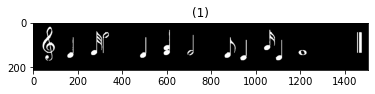

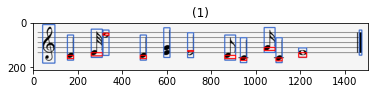

['d1/4', 'e1/16', 'f2/2', 'd1/4', 'f1/2', 'd1/8', 'c1/4', 'g1/16', 'c1/4', 'e1/1']


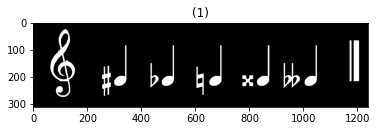

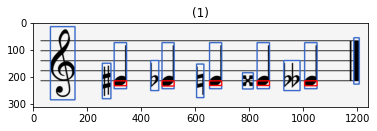

['e#1/4', 'e&1/4', 'e1/4', 'e##1/4', 'e&&1/4']


In [ ]:

#the working cell to get contours
path = outpath
files = tcfiles
images = tcimgs
start_time = time.time()
for i , img in enumerate(images) :
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    hist = histogram(img,nbins=256,source_range='dtype')
    hist_acc =np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
  
    if ( tratio < 4):
        bimg = segement_hand_written(img)
    elif ( 75 > tratio > 4):
        bimg = binraization(img,window,35)
    else: 
        bimg = (img > 150).astype("uint8")
        
    bimg2 = bimg.copy()
    t,d = get_lengthes(bimg)
    csl , c = get_candidates_lines(bimg2,t) 
    fcsl ,c = filter_candidates_lines(csl,c,t,d)
    lines, d2 = getLines(csl)
    #print(lines)
    img_isolated = remove_staff_lines(bimg,t,d , tratio < 4 )
    img_isolated = img_isolated.astype("uint8")
    show_images([img_isolated])
    boxes = getContours(img_isolated) # now we have contours after fixing
    boxes = sorted(boxes, key=lambda t: t[0])
    notes = []
    accidentals = "" # Accidentals # &  
    for box in boxes:
        x,y,w,h = box
        cv2.rectangle(cimg,(x,y),(x+w,y+h),(50,100,200),3)
        croped = img_isolated[y:y+h, x:x+w]
        features = extract_hog_features(croped)
        note_type = str(classes[np.argmax( nn.predict_proba([features]))])
        
        if (len(note_type) >= 3 and note_type[1] == '_') or note_type == "w":
            f = '1'
            if note_type != "w":
                f = note_type.split('_')[1]
           
            heads = None
            if note_type[0] == 'a' or note_type[0] == 'w':
                heads = getNoteHeads(croped, d2) # heads boxes
            elif note_type[0] == 'b':
                heads = getBeamHeads(croped, d2)
            
            if heads is None:
                continue
            
            for head in heads:
                xh,yh,wh,hh = head
                yh = yh + (hh // 2) + y
                xh = xh + x
                #print(yh)
                idx = np.abs(lines - yh).argmin()
                char = line_to_char[idx]
                char = char[:1] + accidentals + char[1:]
                accidentals = ""
                notes.append(char + '/' + f)
                cv2.rectangle(cimg, (xh,yh), (xh+wh,yh+hh), (255,0,0),3)
        elif note_type == "sharp":
            accidentals = "#"
        elif note_type == "flat":
            accidentals = "&"
        elif note_type == "double_sharp":
            accidentals = "##"
        elif note_type == "double_flat":
            accidentals = "&&"
        
    show_images([cimg])
    print(notes)
print("--- %s seconds ---" % (time.time() - start_time))
    

In [13]:
img = cv2.imread(os.path.join(outpath,"isolated08.PNG"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

boxes = getContours(img) # now we have contours after fixing
for box in boxes:
    x,y,w,h = box
    croped = img[y:y+h, x:x+w]
    features = extract_hog_features(croped)
    note_type = classes[np.argmax( nn.predict_proba([features]))]
    if note_type[0] == 'b' or note_type[0] == 'a':
        print(note_type)
        heads = getNoteHeads(croped) # heads boxes

barline


TypeError: getNoteHeads() missing 1 required positional argument: 'd'

In [ ]:
    img = cv2.imread(os.path.join(inpath,"4.jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    fimg = median(img)
    glares = (fimg > 195)
    io.imsave("1-glares.jpg",(glares*255).astype("uint8"))
    bimg = binraization(fimg,window,7)
    io.imsave("2-binary.jpg",(bimg*255).astype("uint8"))
    output = (bimg ) - (glares)
    io.imsave("3-binary.jpg",(output*255).astype("uint8"))
    output = median(output)
    output = binary_dilation(1-output)
    vse = np.array([[0,1,0],
                    [0,1,0],
                    [0,1,0]      ])

    hse = np.array([[0,0,0],
                    [1,1,1],
                    [0,0,0]
    ])
    output = binary_dilation(output , vse)
    output = binary_dilation(output , hse)
    output = 1 - output
    io.imsave("4-binary.jpg",(output*255).astype("uint8"))
    t,d = get_lengthes(output)
    print(t , d)
    csl , c = get_candidates_lines(output,t) 
    io.imsave("5-candidates.jpg",(csl*255).astype("uint8"))
    csl , c = filter_candidates_lines(csl ,c,t,d) 
    io.imsave("6-filtered-candidates.jpg",(csl*255).astype("uint8"))

In [ ]:
    img = cv2.imread(os.path.join(inpath,"08.png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    hist = histogram(img,nbins=256,source_range='dtype')
    hist_acc =np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
  
    if ( tratio < 4):
        bimg = segement_hand_written(img)
    elif ( 75 > tratio > 4):
        bimg = binraization(img,window,35)
    else: 
        bimg = (img > 150).astype("uint8")
    t,d = get_lengthes(bimg)
    img_isolated = remove_staff_lines(bimg,t,d , tratio < 4 )
    img_isolated = img_isolated.astype("uint8")
    show_images([img_isolated])
    boxes = getContours(img_isolated) # now we have contours after fixing
    boxes = sorted(boxes, key=lambda t: t[0])
    notes = []
    for box in boxes:
        x,y,w,h = box
        cv2.rectangle(cimg,(x,y),(x+w,y+h),(50,100,200),3)
        croped = img_isolated[y:y+h, x:x+w]
        features = extract_hog_features(croped)
        note_type = classes[np.argmax( nn.predict_proba([features]))]
        if note_type[0] == 'b' or note_type[0] == 'a':
            f = note_type.split('_')[1]
            heads = getNoteHeads(croped, d) # heads boxes
            for head in heads:
                xh,yh,wh,hh = head
                yh = yh + (hh // 2) + y
                xh = xh + (hh // 2) + x
                print(yh)
                idx = np.abs(lines - yh).argmin()
                char = line_to_char[idx]
                notes.append(char + '/' + f)
                cv2.rectangle(cimg, (xh,yh), (xh+wh,yh+hh), (255,0,0),3)
    show_images([cimg])
    print(notes)

In [ ]:
    hist = histogram(img,nbins=256,source_range='dtype')
    hist_acc =np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
  
    if ( tratio < 4):
        #the photo is hand written
    elif ( 75 > tratio > 4):
        #the photo is camera captured
    else: 
        #the photo is scanned

In [ ]:
    img = cv2.imread(os.path.join(inpath,"09.png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    hist = histogram(img,nbins=256,source_range='dtype')
    hist_acc =np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
    if ( tratio < 4):
        bimg = segement_hand_written(img)
    elif ( 75 > tratio > 4):
        bimg = binraization(img,window,35)
    else: 
        bimg = (img > 150).astype("uint8")
    io.imsave("0-binary.jpg",(bimg*255).astype("uint8"))
    t,d = get_lengthes(bimg)
    img_isolated = remove_staff_lines(bimg,t,d,tratio < 4)
    img_isolated = img_isolated.astype("uint8")
    show_images([img_isolated])
    io.imsave("5-isolated.jpg",img_isolated)
    io.imsave("6-isolated.jpg",((bimg-csl)).astype("uint8"))